# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

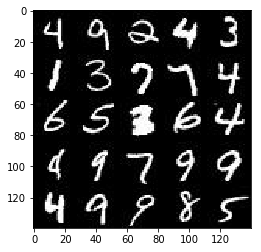

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

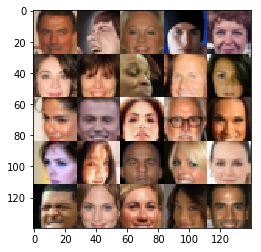

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf
import numpy as np

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, [None,image_width,image_height,image_channels], name='Real_Input')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='Z_Input')
    learning_rate = tf.placeholder(tf.float32, name='Learning_Rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/paperspace/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/paperspace/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/paperspace/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/paperspace/anaconda3/lib/python3.6/sit

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [9]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    keep_prob = 0.5
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha=0.15
        x1 = tf.layers.conv2d(images, 64, 5
                              , strides=2
                              , padding='same'
                              , kernel_initializer= tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5
                              , strides=2
                              , padding='same'
                              , kernel_initializer= tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)

        x3 = tf.layers.conv2d(relu1, 256, 5
                              , strides=2
                              , padding='same'
                              , kernel_initializer= tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        
        flat = tf.reshape(relu3, (-1, 7*7*256))
        flat = tf.nn.dropout(flat, keep_prob)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAoutT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [22]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        alpha=0.15  
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5
                                        , strides=2
                                        , padding='same'
                                       ,kernel_initializer= tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')

        # 28x28x5 now
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [23]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real)*(1.0 - smooth)))

    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [24]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [25]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    
    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()


### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [26]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    image_channels=1
    if data_image_mode =="RGB":
        image_channels = 3


    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], image_channels, 128)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)

   

    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps+=1
                # batch images
                batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], image_channels)
                batch_images = batch_images*2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z,lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images,lr:learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                if steps % 100 == 0:
                    show_generator_output(sess=sess, n_images=30, input_z=input_z, out_channel_dim=image_channels, image_mode=data_image_mode)


      # saver.save(sess, './checkpoints/generator.ckpt')

    #with open('samples.pkl', 'wb') as f:
     #   pkl.dump(samples, f)

    return losses, samples

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3610... Generator Loss: 5.5142
Epoch 1/2... Discriminator Loss: 0.4061... Generator Loss: 6.5238
Epoch 1/2... Discriminator Loss: 0.5093... Generator Loss: 7.8008
Epoch 1/2... Discriminator Loss: 0.4329... Generator Loss: 4.9277
Epoch 1/2... Discriminator Loss: 0.9330... Generator Loss: 4.6433
Epoch 1/2... Discriminator Loss: 0.4738... Generator Loss: 3.5413
Epoch 1/2... Discriminator Loss: 0.4538... Generator Loss: 3.3575
Epoch 1/2... Discriminator Loss: 0.4258... Generator Loss: 3.8181
Epoch 1/2... Discriminator Loss: 0.3632... Generator Loss: 8.6250
Epoch 1/2... Discriminator Loss: 0.4570... Generator Loss: 5.2342


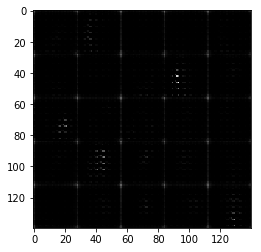

Epoch 1/2... Discriminator Loss: 0.3822... Generator Loss: 5.2987
Epoch 1/2... Discriminator Loss: 0.3920... Generator Loss: 6.1332
Epoch 1/2... Discriminator Loss: 0.3853... Generator Loss: 6.2574
Epoch 1/2... Discriminator Loss: 0.3589... Generator Loss: 5.5163
Epoch 1/2... Discriminator Loss: 2.7065... Generator Loss: 0.3029
Epoch 1/2... Discriminator Loss: 1.0160... Generator Loss: 2.2269
Epoch 1/2... Discriminator Loss: 0.9443... Generator Loss: 1.9580
Epoch 1/2... Discriminator Loss: 2.2917... Generator Loss: 0.4142
Epoch 1/2... Discriminator Loss: 1.4930... Generator Loss: 0.8626
Epoch 1/2... Discriminator Loss: 1.3326... Generator Loss: 1.3785


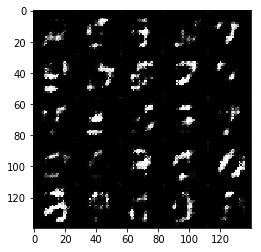

Epoch 1/2... Discriminator Loss: 1.6419... Generator Loss: 0.5733
Epoch 1/2... Discriminator Loss: 1.2233... Generator Loss: 1.9363
Epoch 1/2... Discriminator Loss: 1.2994... Generator Loss: 1.9449
Epoch 1/2... Discriminator Loss: 1.4557... Generator Loss: 0.8289
Epoch 1/2... Discriminator Loss: 1.2207... Generator Loss: 1.8011
Epoch 1/2... Discriminator Loss: 1.4226... Generator Loss: 1.1524
Epoch 1/2... Discriminator Loss: 1.3381... Generator Loss: 1.5991
Epoch 1/2... Discriminator Loss: 1.4868... Generator Loss: 1.6505
Epoch 1/2... Discriminator Loss: 1.8419... Generator Loss: 1.1682
Epoch 1/2... Discriminator Loss: 1.3228... Generator Loss: 0.8058


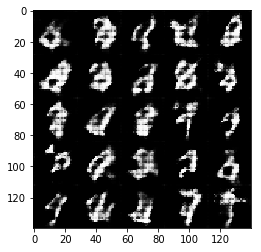

Epoch 1/2... Discriminator Loss: 1.8749... Generator Loss: 1.8744
Epoch 1/2... Discriminator Loss: 1.4691... Generator Loss: 0.9357
Epoch 1/2... Discriminator Loss: 1.5141... Generator Loss: 0.7849
Epoch 1/2... Discriminator Loss: 1.3783... Generator Loss: 1.0036
Epoch 1/2... Discriminator Loss: 1.4477... Generator Loss: 0.7347
Epoch 1/2... Discriminator Loss: 1.3174... Generator Loss: 0.9307
Epoch 1/2... Discriminator Loss: 1.3160... Generator Loss: 1.2391
Epoch 1/2... Discriminator Loss: 1.4048... Generator Loss: 0.7332
Epoch 1/2... Discriminator Loss: 1.2853... Generator Loss: 0.9630
Epoch 1/2... Discriminator Loss: 1.3980... Generator Loss: 0.5768


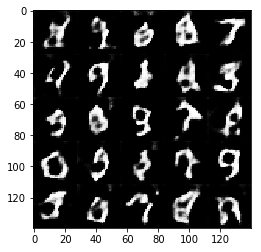

Epoch 1/2... Discriminator Loss: 1.6111... Generator Loss: 0.6368
Epoch 1/2... Discriminator Loss: 1.3461... Generator Loss: 0.7619
Epoch 1/2... Discriminator Loss: 1.4323... Generator Loss: 1.4030
Epoch 1/2... Discriminator Loss: 1.3918... Generator Loss: 1.0432
Epoch 1/2... Discriminator Loss: 1.4087... Generator Loss: 0.8705
Epoch 1/2... Discriminator Loss: 1.4399... Generator Loss: 1.0628
Epoch 1/2... Discriminator Loss: 1.2819... Generator Loss: 1.3092
Epoch 1/2... Discriminator Loss: 1.3776... Generator Loss: 0.9770
Epoch 1/2... Discriminator Loss: 1.5239... Generator Loss: 0.7944
Epoch 1/2... Discriminator Loss: 1.6218... Generator Loss: 1.0248


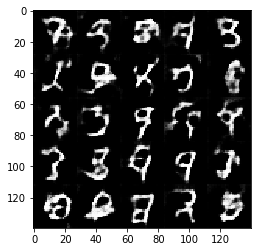

Epoch 1/2... Discriminator Loss: 1.2615... Generator Loss: 0.9519
Epoch 1/2... Discriminator Loss: 1.3484... Generator Loss: 0.9739
Epoch 1/2... Discriminator Loss: 1.3655... Generator Loss: 0.7957
Epoch 1/2... Discriminator Loss: 1.4279... Generator Loss: 1.1126
Epoch 1/2... Discriminator Loss: 1.1732... Generator Loss: 1.3063
Epoch 1/2... Discriminator Loss: 1.5253... Generator Loss: 0.6116
Epoch 1/2... Discriminator Loss: 1.2599... Generator Loss: 0.8130
Epoch 1/2... Discriminator Loss: 1.5007... Generator Loss: 0.8147
Epoch 1/2... Discriminator Loss: 1.3934... Generator Loss: 0.9793
Epoch 1/2... Discriminator Loss: 1.3678... Generator Loss: 0.7211


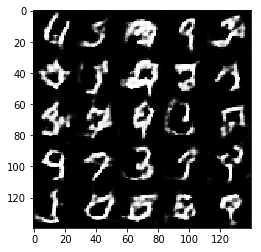

Epoch 1/2... Discriminator Loss: 1.3012... Generator Loss: 0.8944
Epoch 1/2... Discriminator Loss: 1.4328... Generator Loss: 0.9703
Epoch 1/2... Discriminator Loss: 1.2177... Generator Loss: 1.3608
Epoch 1/2... Discriminator Loss: 1.5271... Generator Loss: 1.0626
Epoch 1/2... Discriminator Loss: 1.6500... Generator Loss: 1.1596
Epoch 1/2... Discriminator Loss: 1.5266... Generator Loss: 0.7887
Epoch 1/2... Discriminator Loss: 1.4607... Generator Loss: 0.9618
Epoch 1/2... Discriminator Loss: 1.4722... Generator Loss: 0.9265
Epoch 1/2... Discriminator Loss: 1.5783... Generator Loss: 1.3517
Epoch 1/2... Discriminator Loss: 1.3158... Generator Loss: 1.1266


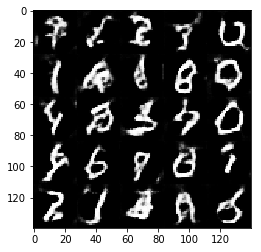

Epoch 1/2... Discriminator Loss: 1.4670... Generator Loss: 1.0480
Epoch 1/2... Discriminator Loss: 1.4252... Generator Loss: 0.8935
Epoch 1/2... Discriminator Loss: 1.4502... Generator Loss: 0.6900
Epoch 1/2... Discriminator Loss: 1.3225... Generator Loss: 1.0043
Epoch 1/2... Discriminator Loss: 1.5214... Generator Loss: 1.2730
Epoch 1/2... Discriminator Loss: 1.6038... Generator Loss: 0.7652
Epoch 1/2... Discriminator Loss: 1.4137... Generator Loss: 1.0578
Epoch 1/2... Discriminator Loss: 1.5542... Generator Loss: 0.6221
Epoch 1/2... Discriminator Loss: 1.7595... Generator Loss: 0.5745
Epoch 1/2... Discriminator Loss: 1.4425... Generator Loss: 1.2394


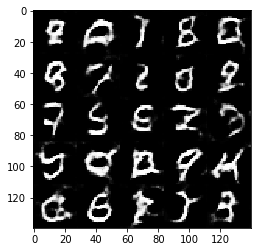

Epoch 1/2... Discriminator Loss: 1.5720... Generator Loss: 0.5632
Epoch 1/2... Discriminator Loss: 1.5279... Generator Loss: 0.8636
Epoch 1/2... Discriminator Loss: 1.2836... Generator Loss: 0.7785
Epoch 1/2... Discriminator Loss: 1.2985... Generator Loss: 0.7212
Epoch 1/2... Discriminator Loss: 1.3891... Generator Loss: 0.8552
Epoch 1/2... Discriminator Loss: 1.4453... Generator Loss: 0.9033
Epoch 1/2... Discriminator Loss: 1.2568... Generator Loss: 1.3168
Epoch 1/2... Discriminator Loss: 1.3626... Generator Loss: 0.8321
Epoch 1/2... Discriminator Loss: 1.3167... Generator Loss: 1.1382
Epoch 1/2... Discriminator Loss: 1.3645... Generator Loss: 0.8267


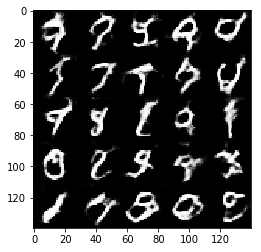

Epoch 1/2... Discriminator Loss: 1.4136... Generator Loss: 1.5330
Epoch 1/2... Discriminator Loss: 1.2861... Generator Loss: 0.9575
Epoch 1/2... Discriminator Loss: 1.3380... Generator Loss: 0.8874
Epoch 1/2... Discriminator Loss: 1.3459... Generator Loss: 0.9282
Epoch 1/2... Discriminator Loss: 1.4430... Generator Loss: 1.0720
Epoch 1/2... Discriminator Loss: 1.3797... Generator Loss: 0.6315
Epoch 1/2... Discriminator Loss: 1.3499... Generator Loss: 0.8324
Epoch 1/2... Discriminator Loss: 1.1856... Generator Loss: 1.0399
Epoch 1/2... Discriminator Loss: 1.2071... Generator Loss: 1.1298
Epoch 1/2... Discriminator Loss: 1.3561... Generator Loss: 0.9679


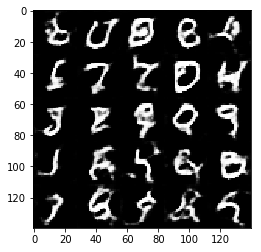

Epoch 1/2... Discriminator Loss: 1.2990... Generator Loss: 0.5947
Epoch 1/2... Discriminator Loss: 1.4740... Generator Loss: 1.1994
Epoch 1/2... Discriminator Loss: 1.3309... Generator Loss: 0.9119
Epoch 1/2... Discriminator Loss: 1.3776... Generator Loss: 0.6614
Epoch 1/2... Discriminator Loss: 1.3657... Generator Loss: 0.7089
Epoch 1/2... Discriminator Loss: 1.5389... Generator Loss: 0.7571
Epoch 1/2... Discriminator Loss: 1.4153... Generator Loss: 1.2687
Epoch 1/2... Discriminator Loss: 1.5984... Generator Loss: 0.5302
Epoch 1/2... Discriminator Loss: 1.3195... Generator Loss: 1.4467
Epoch 1/2... Discriminator Loss: 1.4880... Generator Loss: 1.0004


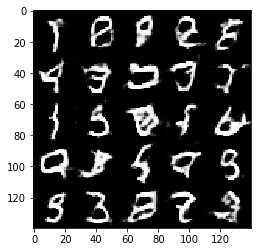

Epoch 1/2... Discriminator Loss: 1.4324... Generator Loss: 0.9355
Epoch 1/2... Discriminator Loss: 1.3933... Generator Loss: 1.1605
Epoch 1/2... Discriminator Loss: 1.4793... Generator Loss: 0.9497
Epoch 1/2... Discriminator Loss: 1.6724... Generator Loss: 1.3877
Epoch 1/2... Discriminator Loss: 1.5328... Generator Loss: 0.5056
Epoch 1/2... Discriminator Loss: 1.3748... Generator Loss: 0.8608
Epoch 1/2... Discriminator Loss: 1.4804... Generator Loss: 0.8607
Epoch 1/2... Discriminator Loss: 1.4423... Generator Loss: 1.1943
Epoch 1/2... Discriminator Loss: 1.4570... Generator Loss: 1.1662
Epoch 1/2... Discriminator Loss: 1.4834... Generator Loss: 0.6070


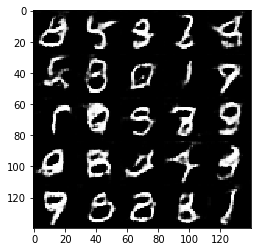

Epoch 1/2... Discriminator Loss: 1.3308... Generator Loss: 0.9339
Epoch 1/2... Discriminator Loss: 1.5528... Generator Loss: 0.5232
Epoch 1/2... Discriminator Loss: 1.4735... Generator Loss: 0.8790
Epoch 1/2... Discriminator Loss: 1.3976... Generator Loss: 1.2065
Epoch 1/2... Discriminator Loss: 1.6350... Generator Loss: 0.5291
Epoch 1/2... Discriminator Loss: 1.1852... Generator Loss: 1.0944
Epoch 1/2... Discriminator Loss: 1.6481... Generator Loss: 1.0708
Epoch 1/2... Discriminator Loss: 1.3580... Generator Loss: 0.8278
Epoch 1/2... Discriminator Loss: 1.5138... Generator Loss: 0.6387
Epoch 1/2... Discriminator Loss: 1.3172... Generator Loss: 0.9452


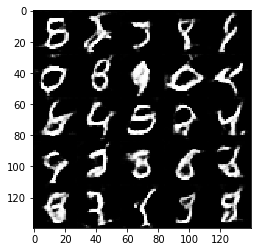

Epoch 1/2... Discriminator Loss: 1.3765... Generator Loss: 0.8983
Epoch 1/2... Discriminator Loss: 1.3839... Generator Loss: 0.7213
Epoch 1/2... Discriminator Loss: 1.4486... Generator Loss: 0.6987
Epoch 1/2... Discriminator Loss: 1.2778... Generator Loss: 0.9902
Epoch 1/2... Discriminator Loss: 1.3454... Generator Loss: 0.8969
Epoch 1/2... Discriminator Loss: 1.3664... Generator Loss: 0.8295
Epoch 1/2... Discriminator Loss: 1.2862... Generator Loss: 0.9229
Epoch 1/2... Discriminator Loss: 1.5725... Generator Loss: 0.5866
Epoch 1/2... Discriminator Loss: 1.3118... Generator Loss: 0.9729
Epoch 1/2... Discriminator Loss: 1.3202... Generator Loss: 0.9523


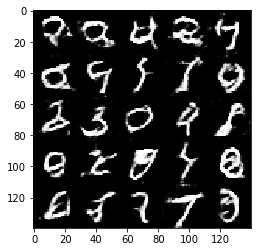

Epoch 1/2... Discriminator Loss: 1.4062... Generator Loss: 0.7883
Epoch 1/2... Discriminator Loss: 1.2540... Generator Loss: 0.7446
Epoch 1/2... Discriminator Loss: 1.3063... Generator Loss: 1.4416
Epoch 1/2... Discriminator Loss: 1.2332... Generator Loss: 0.8324
Epoch 1/2... Discriminator Loss: 1.4438... Generator Loss: 0.7869
Epoch 1/2... Discriminator Loss: 1.3062... Generator Loss: 0.8130
Epoch 1/2... Discriminator Loss: 1.7796... Generator Loss: 0.4984
Epoch 1/2... Discriminator Loss: 1.3183... Generator Loss: 0.8872
Epoch 1/2... Discriminator Loss: 1.2335... Generator Loss: 0.9817
Epoch 1/2... Discriminator Loss: 1.3359... Generator Loss: 0.9839


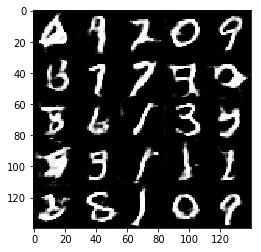

Epoch 1/2... Discriminator Loss: 1.4940... Generator Loss: 0.6859
Epoch 1/2... Discriminator Loss: 1.4122... Generator Loss: 1.0871
Epoch 1/2... Discriminator Loss: 1.3005... Generator Loss: 0.9509
Epoch 1/2... Discriminator Loss: 1.4093... Generator Loss: 0.6176
Epoch 1/2... Discriminator Loss: 1.4520... Generator Loss: 0.8200
Epoch 1/2... Discriminator Loss: 1.4535... Generator Loss: 1.0003
Epoch 1/2... Discriminator Loss: 1.3790... Generator Loss: 0.7427
Epoch 1/2... Discriminator Loss: 1.4558... Generator Loss: 0.9122
Epoch 1/2... Discriminator Loss: 1.4287... Generator Loss: 0.7592
Epoch 1/2... Discriminator Loss: 1.3150... Generator Loss: 0.7594


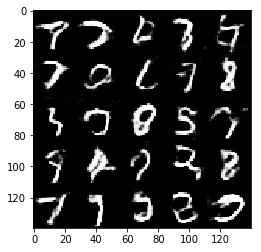

Epoch 1/2... Discriminator Loss: 1.3716... Generator Loss: 0.8380
Epoch 1/2... Discriminator Loss: 1.3230... Generator Loss: 1.3336
Epoch 1/2... Discriminator Loss: 1.3633... Generator Loss: 0.7233
Epoch 1/2... Discriminator Loss: 1.3135... Generator Loss: 0.7526
Epoch 1/2... Discriminator Loss: 1.3126... Generator Loss: 0.7549
Epoch 1/2... Discriminator Loss: 1.5720... Generator Loss: 1.0381
Epoch 1/2... Discriminator Loss: 1.3868... Generator Loss: 0.7741
Epoch 1/2... Discriminator Loss: 1.1781... Generator Loss: 0.8128
Epoch 1/2... Discriminator Loss: 1.3284... Generator Loss: 1.2840
Epoch 1/2... Discriminator Loss: 1.4731... Generator Loss: 0.7644


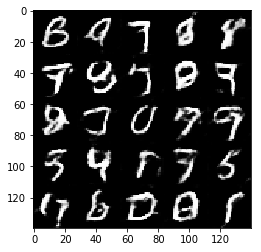

Epoch 1/2... Discriminator Loss: 1.5016... Generator Loss: 0.6954
Epoch 1/2... Discriminator Loss: 1.4217... Generator Loss: 0.8610
Epoch 1/2... Discriminator Loss: 1.3753... Generator Loss: 1.4733
Epoch 1/2... Discriminator Loss: 1.3124... Generator Loss: 1.0855
Epoch 1/2... Discriminator Loss: 1.2907... Generator Loss: 0.9961
Epoch 1/2... Discriminator Loss: 1.4270... Generator Loss: 0.7715
Epoch 1/2... Discriminator Loss: 1.4109... Generator Loss: 0.6674
Epoch 1/2... Discriminator Loss: 1.3549... Generator Loss: 0.7490
Epoch 1/2... Discriminator Loss: 1.5427... Generator Loss: 0.4987
Epoch 1/2... Discriminator Loss: 1.2374... Generator Loss: 1.1409


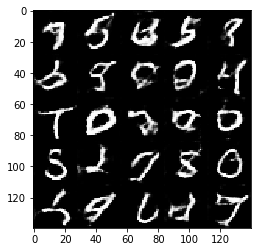

Epoch 1/2... Discriminator Loss: 1.3235... Generator Loss: 1.0854
Epoch 1/2... Discriminator Loss: 1.3886... Generator Loss: 1.0674
Epoch 1/2... Discriminator Loss: 1.2761... Generator Loss: 0.9203
Epoch 1/2... Discriminator Loss: 1.2894... Generator Loss: 0.8547
Epoch 1/2... Discriminator Loss: 1.3997... Generator Loss: 1.3418
Epoch 1/2... Discriminator Loss: 1.1662... Generator Loss: 0.9356
Epoch 1/2... Discriminator Loss: 1.4237... Generator Loss: 1.3131
Epoch 2/2... Discriminator Loss: 1.4402... Generator Loss: 1.2456
Epoch 2/2... Discriminator Loss: 1.4172... Generator Loss: 1.0437
Epoch 2/2... Discriminator Loss: 1.2459... Generator Loss: 1.0937


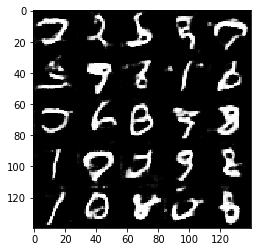

Epoch 2/2... Discriminator Loss: 1.4689... Generator Loss: 1.0877
Epoch 2/2... Discriminator Loss: 1.2787... Generator Loss: 0.8832
Epoch 2/2... Discriminator Loss: 1.2141... Generator Loss: 1.0705
Epoch 2/2... Discriminator Loss: 1.3241... Generator Loss: 0.6706
Epoch 2/2... Discriminator Loss: 1.5766... Generator Loss: 0.4756
Epoch 2/2... Discriminator Loss: 1.3037... Generator Loss: 0.7464
Epoch 2/2... Discriminator Loss: 1.2819... Generator Loss: 1.0896
Epoch 2/2... Discriminator Loss: 1.4539... Generator Loss: 0.8550
Epoch 2/2... Discriminator Loss: 1.4364... Generator Loss: 0.7726
Epoch 2/2... Discriminator Loss: 1.4742... Generator Loss: 0.8800


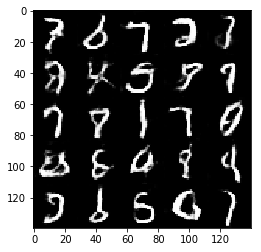

Epoch 2/2... Discriminator Loss: 1.3463... Generator Loss: 0.8227
Epoch 2/2... Discriminator Loss: 1.4035... Generator Loss: 1.0900
Epoch 2/2... Discriminator Loss: 1.2757... Generator Loss: 0.9823
Epoch 2/2... Discriminator Loss: 1.3739... Generator Loss: 0.9252
Epoch 2/2... Discriminator Loss: 1.5240... Generator Loss: 0.6481
Epoch 2/2... Discriminator Loss: 1.3644... Generator Loss: 0.9881
Epoch 2/2... Discriminator Loss: 1.5201... Generator Loss: 0.6561
Epoch 2/2... Discriminator Loss: 1.4177... Generator Loss: 1.1008
Epoch 2/2... Discriminator Loss: 1.6607... Generator Loss: 0.8662
Epoch 2/2... Discriminator Loss: 1.3658... Generator Loss: 1.1829


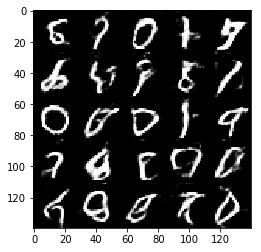

Epoch 2/2... Discriminator Loss: 1.8045... Generator Loss: 0.5160
Epoch 2/2... Discriminator Loss: 1.4296... Generator Loss: 0.8206
Epoch 2/2... Discriminator Loss: 1.3225... Generator Loss: 0.8874
Epoch 2/2... Discriminator Loss: 1.3284... Generator Loss: 0.9894
Epoch 2/2... Discriminator Loss: 1.3659... Generator Loss: 0.7911
Epoch 2/2... Discriminator Loss: 1.2879... Generator Loss: 1.0898
Epoch 2/2... Discriminator Loss: 1.3726... Generator Loss: 0.7796
Epoch 2/2... Discriminator Loss: 1.4199... Generator Loss: 0.7599
Epoch 2/2... Discriminator Loss: 1.3501... Generator Loss: 0.7611
Epoch 2/2... Discriminator Loss: 1.3316... Generator Loss: 0.8857


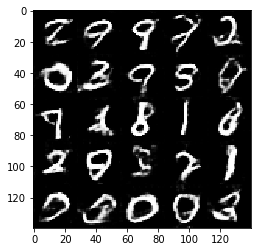

Epoch 2/2... Discriminator Loss: 1.3556... Generator Loss: 0.8690
Epoch 2/2... Discriminator Loss: 1.4511... Generator Loss: 0.8839
Epoch 2/2... Discriminator Loss: 1.3422... Generator Loss: 1.1409
Epoch 2/2... Discriminator Loss: 1.2135... Generator Loss: 0.9742
Epoch 2/2... Discriminator Loss: 1.3196... Generator Loss: 1.0176
Epoch 2/2... Discriminator Loss: 1.4850... Generator Loss: 0.6379
Epoch 2/2... Discriminator Loss: 1.3548... Generator Loss: 0.6071
Epoch 2/2... Discriminator Loss: 1.5477... Generator Loss: 1.1460
Epoch 2/2... Discriminator Loss: 1.3037... Generator Loss: 0.8173
Epoch 2/2... Discriminator Loss: 1.4581... Generator Loss: 0.9143


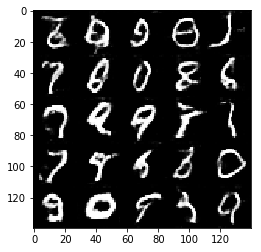

Epoch 2/2... Discriminator Loss: 1.5207... Generator Loss: 0.8333
Epoch 2/2... Discriminator Loss: 1.3858... Generator Loss: 1.1959
Epoch 2/2... Discriminator Loss: 1.2902... Generator Loss: 0.9523
Epoch 2/2... Discriminator Loss: 1.4423... Generator Loss: 0.8027
Epoch 2/2... Discriminator Loss: 1.3539... Generator Loss: 0.7392
Epoch 2/2... Discriminator Loss: 1.4813... Generator Loss: 0.9228
Epoch 2/2... Discriminator Loss: 1.6001... Generator Loss: 0.5887
Epoch 2/2... Discriminator Loss: 1.3191... Generator Loss: 1.2242
Epoch 2/2... Discriminator Loss: 1.2725... Generator Loss: 0.9289
Epoch 2/2... Discriminator Loss: 1.3610... Generator Loss: 0.8348


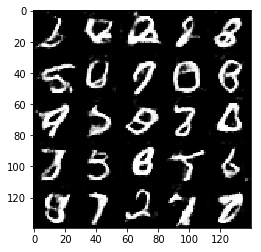

Epoch 2/2... Discriminator Loss: 1.2651... Generator Loss: 0.7395
Epoch 2/2... Discriminator Loss: 1.4243... Generator Loss: 0.6629
Epoch 2/2... Discriminator Loss: 1.2499... Generator Loss: 0.9328
Epoch 2/2... Discriminator Loss: 1.2971... Generator Loss: 1.1495
Epoch 2/2... Discriminator Loss: 1.4037... Generator Loss: 1.2577
Epoch 2/2... Discriminator Loss: 1.2135... Generator Loss: 0.9272
Epoch 2/2... Discriminator Loss: 1.5044... Generator Loss: 0.8076
Epoch 2/2... Discriminator Loss: 1.3439... Generator Loss: 0.8386
Epoch 2/2... Discriminator Loss: 1.3267... Generator Loss: 1.0760
Epoch 2/2... Discriminator Loss: 1.2618... Generator Loss: 0.8157


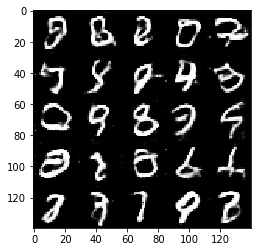

Epoch 2/2... Discriminator Loss: 1.2074... Generator Loss: 0.9347
Epoch 2/2... Discriminator Loss: 1.3582... Generator Loss: 1.3737
Epoch 2/2... Discriminator Loss: 1.5729... Generator Loss: 0.8116
Epoch 2/2... Discriminator Loss: 1.4506... Generator Loss: 0.6533
Epoch 2/2... Discriminator Loss: 1.2533... Generator Loss: 0.7950
Epoch 2/2... Discriminator Loss: 1.3532... Generator Loss: 0.7921
Epoch 2/2... Discriminator Loss: 1.4330... Generator Loss: 1.4564
Epoch 2/2... Discriminator Loss: 1.2347... Generator Loss: 0.8731
Epoch 2/2... Discriminator Loss: 1.3457... Generator Loss: 1.3035
Epoch 2/2... Discriminator Loss: 1.2156... Generator Loss: 0.7281


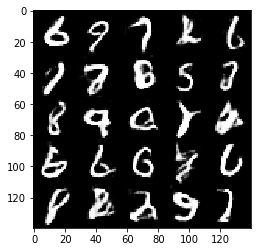

Epoch 2/2... Discriminator Loss: 1.2723... Generator Loss: 0.9990
Epoch 2/2... Discriminator Loss: 1.2874... Generator Loss: 0.9678
Epoch 2/2... Discriminator Loss: 1.3661... Generator Loss: 1.0772
Epoch 2/2... Discriminator Loss: 1.2539... Generator Loss: 0.7770
Epoch 2/2... Discriminator Loss: 1.3834... Generator Loss: 1.0184
Epoch 2/2... Discriminator Loss: 1.3246... Generator Loss: 1.0968
Epoch 2/2... Discriminator Loss: 1.1935... Generator Loss: 1.0618
Epoch 2/2... Discriminator Loss: 1.4185... Generator Loss: 0.7767
Epoch 2/2... Discriminator Loss: 1.3522... Generator Loss: 1.0902
Epoch 2/2... Discriminator Loss: 1.2986... Generator Loss: 0.9802


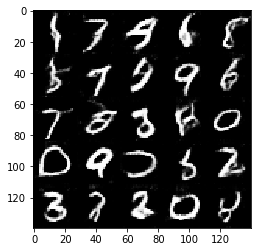

Epoch 2/2... Discriminator Loss: 1.4565... Generator Loss: 0.8058
Epoch 2/2... Discriminator Loss: 1.3914... Generator Loss: 1.1259
Epoch 2/2... Discriminator Loss: 1.5298... Generator Loss: 0.6367
Epoch 2/2... Discriminator Loss: 1.3153... Generator Loss: 1.0480
Epoch 2/2... Discriminator Loss: 1.4710... Generator Loss: 0.6487
Epoch 2/2... Discriminator Loss: 1.3483... Generator Loss: 0.8604
Epoch 2/2... Discriminator Loss: 1.3411... Generator Loss: 0.7751
Epoch 2/2... Discriminator Loss: 1.5670... Generator Loss: 0.9570
Epoch 2/2... Discriminator Loss: 1.3861... Generator Loss: 0.8022
Epoch 2/2... Discriminator Loss: 1.3639... Generator Loss: 0.6708


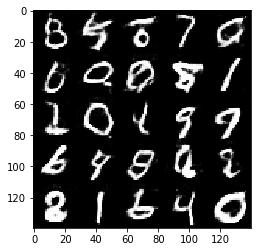

Epoch 2/2... Discriminator Loss: 1.2369... Generator Loss: 1.1497
Epoch 2/2... Discriminator Loss: 1.3292... Generator Loss: 1.1350
Epoch 2/2... Discriminator Loss: 1.3499... Generator Loss: 1.1177
Epoch 2/2... Discriminator Loss: 1.2800... Generator Loss: 0.8416
Epoch 2/2... Discriminator Loss: 1.3957... Generator Loss: 1.0761
Epoch 2/2... Discriminator Loss: 1.2280... Generator Loss: 0.8504
Epoch 2/2... Discriminator Loss: 1.1987... Generator Loss: 1.1058
Epoch 2/2... Discriminator Loss: 1.4893... Generator Loss: 1.2271
Epoch 2/2... Discriminator Loss: 1.3427... Generator Loss: 1.2202
Epoch 2/2... Discriminator Loss: 1.3551... Generator Loss: 0.9604


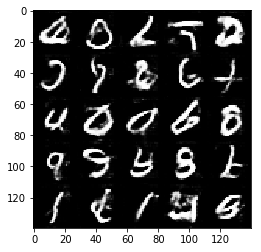

Epoch 2/2... Discriminator Loss: 1.2906... Generator Loss: 1.0763
Epoch 2/2... Discriminator Loss: 1.3802... Generator Loss: 1.0982
Epoch 2/2... Discriminator Loss: 1.3425... Generator Loss: 0.7969
Epoch 2/2... Discriminator Loss: 1.4433... Generator Loss: 0.7663
Epoch 2/2... Discriminator Loss: 1.4723... Generator Loss: 0.7144
Epoch 2/2... Discriminator Loss: 1.3314... Generator Loss: 0.7413
Epoch 2/2... Discriminator Loss: 1.4780... Generator Loss: 0.8143
Epoch 2/2... Discriminator Loss: 1.3078... Generator Loss: 0.7642
Epoch 2/2... Discriminator Loss: 1.2206... Generator Loss: 1.1443
Epoch 2/2... Discriminator Loss: 1.3762... Generator Loss: 0.7192


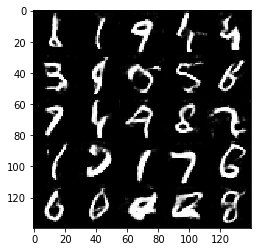

Epoch 2/2... Discriminator Loss: 1.2960... Generator Loss: 1.0052
Epoch 2/2... Discriminator Loss: 1.3159... Generator Loss: 0.6113
Epoch 2/2... Discriminator Loss: 1.2568... Generator Loss: 1.1084
Epoch 2/2... Discriminator Loss: 1.3141... Generator Loss: 1.0454
Epoch 2/2... Discriminator Loss: 1.4858... Generator Loss: 0.6419
Epoch 2/2... Discriminator Loss: 1.4270... Generator Loss: 0.7459
Epoch 2/2... Discriminator Loss: 1.5185... Generator Loss: 1.2084
Epoch 2/2... Discriminator Loss: 1.3249... Generator Loss: 0.8983
Epoch 2/2... Discriminator Loss: 1.3271... Generator Loss: 0.7649
Epoch 2/2... Discriminator Loss: 1.4469... Generator Loss: 0.5986


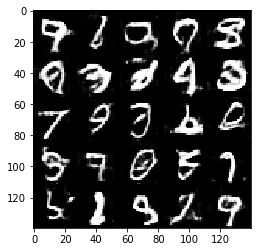

Epoch 2/2... Discriminator Loss: 1.4226... Generator Loss: 0.8759
Epoch 2/2... Discriminator Loss: 1.2614... Generator Loss: 1.0551
Epoch 2/2... Discriminator Loss: 1.4571... Generator Loss: 1.4795
Epoch 2/2... Discriminator Loss: 1.3522... Generator Loss: 0.7341
Epoch 2/2... Discriminator Loss: 1.5052... Generator Loss: 0.5484
Epoch 2/2... Discriminator Loss: 1.3987... Generator Loss: 0.8771
Epoch 2/2... Discriminator Loss: 1.3537... Generator Loss: 0.9348
Epoch 2/2... Discriminator Loss: 1.5070... Generator Loss: 0.8463
Epoch 2/2... Discriminator Loss: 1.2882... Generator Loss: 0.8397
Epoch 2/2... Discriminator Loss: 1.3925... Generator Loss: 0.8608


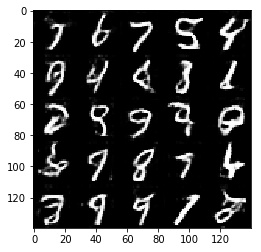

Epoch 2/2... Discriminator Loss: 1.3913... Generator Loss: 1.2298
Epoch 2/2... Discriminator Loss: 1.2955... Generator Loss: 0.8647
Epoch 2/2... Discriminator Loss: 1.3687... Generator Loss: 0.7054
Epoch 2/2... Discriminator Loss: 1.4558... Generator Loss: 0.8052
Epoch 2/2... Discriminator Loss: 1.3955... Generator Loss: 0.7950
Epoch 2/2... Discriminator Loss: 1.4103... Generator Loss: 0.7529
Epoch 2/2... Discriminator Loss: 1.3690... Generator Loss: 0.9082
Epoch 2/2... Discriminator Loss: 1.3382... Generator Loss: 0.8409
Epoch 2/2... Discriminator Loss: 1.2939... Generator Loss: 0.8982
Epoch 2/2... Discriminator Loss: 1.4134... Generator Loss: 0.8348


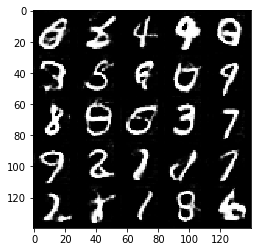

Epoch 2/2... Discriminator Loss: 1.3645... Generator Loss: 0.8576
Epoch 2/2... Discriminator Loss: 1.4332... Generator Loss: 0.7105
Epoch 2/2... Discriminator Loss: 1.3205... Generator Loss: 0.8104
Epoch 2/2... Discriminator Loss: 1.1990... Generator Loss: 1.0441
Epoch 2/2... Discriminator Loss: 1.3277... Generator Loss: 0.7766
Epoch 2/2... Discriminator Loss: 1.3596... Generator Loss: 0.9564
Epoch 2/2... Discriminator Loss: 1.3388... Generator Loss: 0.6842
Epoch 2/2... Discriminator Loss: 1.6275... Generator Loss: 0.7450
Epoch 2/2... Discriminator Loss: 1.2776... Generator Loss: 0.8738
Epoch 2/2... Discriminator Loss: 1.3323... Generator Loss: 0.7025


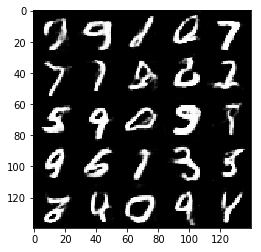

Epoch 2/2... Discriminator Loss: 1.4388... Generator Loss: 0.6725
Epoch 2/2... Discriminator Loss: 1.5270... Generator Loss: 0.4818
Epoch 2/2... Discriminator Loss: 1.5419... Generator Loss: 0.9286
Epoch 2/2... Discriminator Loss: 1.3805... Generator Loss: 0.6526
Epoch 2/2... Discriminator Loss: 1.3254... Generator Loss: 1.1306
Epoch 2/2... Discriminator Loss: 1.3995... Generator Loss: 0.9490
Epoch 2/2... Discriminator Loss: 1.2919... Generator Loss: 0.7527
Epoch 2/2... Discriminator Loss: 1.3259... Generator Loss: 0.7660
Epoch 2/2... Discriminator Loss: 1.3383... Generator Loss: 1.1341
Epoch 2/2... Discriminator Loss: 1.4199... Generator Loss: 0.8692


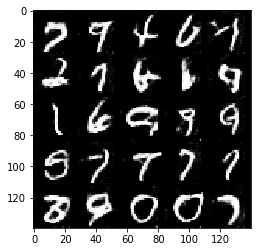

Epoch 2/2... Discriminator Loss: 1.3838... Generator Loss: 1.0619
Epoch 2/2... Discriminator Loss: 1.3214... Generator Loss: 1.1963
Epoch 2/2... Discriminator Loss: 1.3212... Generator Loss: 0.9048
Epoch 2/2... Discriminator Loss: 1.3310... Generator Loss: 0.8572
Epoch 2/2... Discriminator Loss: 1.3622... Generator Loss: 0.7789
Epoch 2/2... Discriminator Loss: 1.6747... Generator Loss: 0.5174
Epoch 2/2... Discriminator Loss: 1.3807... Generator Loss: 0.6685
Epoch 2/2... Discriminator Loss: 1.3732... Generator Loss: 0.8033
Epoch 2/2... Discriminator Loss: 1.4368... Generator Loss: 0.6876
Epoch 2/2... Discriminator Loss: 1.4678... Generator Loss: 1.0855


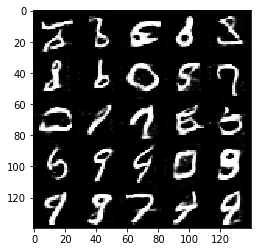

Epoch 2/2... Discriminator Loss: 1.5150... Generator Loss: 0.5980
Epoch 2/2... Discriminator Loss: 1.3823... Generator Loss: 0.7447
Epoch 2/2... Discriminator Loss: 1.4753... Generator Loss: 0.9242
Epoch 2/2... Discriminator Loss: 1.3702... Generator Loss: 1.1983
Epoch 2/2... Discriminator Loss: 1.5238... Generator Loss: 0.9333
Epoch 2/2... Discriminator Loss: 1.2916... Generator Loss: 0.9772
Epoch 2/2... Discriminator Loss: 1.2841... Generator Loss: 0.7511
Epoch 2/2... Discriminator Loss: 1.3896... Generator Loss: 0.8673
Epoch 2/2... Discriminator Loss: 1.2664... Generator Loss: 1.1760
Epoch 2/2... Discriminator Loss: 1.4883... Generator Loss: 0.9128


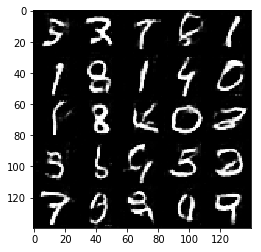

Epoch 2/2... Discriminator Loss: 1.4541... Generator Loss: 0.5883
Epoch 2/2... Discriminator Loss: 1.2857... Generator Loss: 0.7663
Epoch 2/2... Discriminator Loss: 1.3469... Generator Loss: 0.9341
Epoch 2/2... Discriminator Loss: 1.2823... Generator Loss: 1.1365
Epoch 2/2... Discriminator Loss: 1.4768... Generator Loss: 0.9287


In [27]:
batch_size = 32
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5




"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4318... Generator Loss: 3.8275
Epoch 1/1... Discriminator Loss: 0.5468... Generator Loss: 3.2431
Epoch 1/1... Discriminator Loss: 0.4116... Generator Loss: 4.4265
Epoch 1/1... Discriminator Loss: 0.4568... Generator Loss: 3.4046
Epoch 1/1... Discriminator Loss: 0.3975... Generator Loss: 4.6246
Epoch 1/1... Discriminator Loss: 0.6597... Generator Loss: 6.5566
Epoch 1/1... Discriminator Loss: 0.6298... Generator Loss: 2.3369
Epoch 1/1... Discriminator Loss: 0.9897... Generator Loss: 1.6574
Epoch 1/1... Discriminator Loss: 0.8181... Generator Loss: 1.9181
Epoch 1/1... Discriminator Loss: 0.8255... Generator Loss: 2.1491


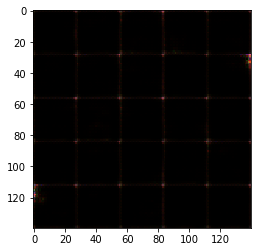

Epoch 1/1... Discriminator Loss: 0.6540... Generator Loss: 2.3040
Epoch 1/1... Discriminator Loss: 0.4133... Generator Loss: 4.4059
Epoch 1/1... Discriminator Loss: 0.4264... Generator Loss: 3.9175
Epoch 1/1... Discriminator Loss: 0.4510... Generator Loss: 2.9240
Epoch 1/1... Discriminator Loss: 0.5019... Generator Loss: 2.3032
Epoch 1/1... Discriminator Loss: 0.7605... Generator Loss: 4.9964
Epoch 1/1... Discriminator Loss: 1.6145... Generator Loss: 4.9940
Epoch 1/1... Discriminator Loss: 1.8599... Generator Loss: 0.4260
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.6553
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.6527


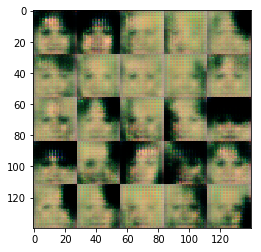

Epoch 1/1... Discriminator Loss: 0.9419... Generator Loss: 1.2710
Epoch 1/1... Discriminator Loss: 0.8449... Generator Loss: 1.5856
Epoch 1/1... Discriminator Loss: 0.9632... Generator Loss: 2.0366
Epoch 1/1... Discriminator Loss: 1.1237... Generator Loss: 1.3443
Epoch 1/1... Discriminator Loss: 1.8281... Generator Loss: 0.4190
Epoch 1/1... Discriminator Loss: 0.7412... Generator Loss: 2.1716
Epoch 1/1... Discriminator Loss: 0.6806... Generator Loss: 2.1157
Epoch 1/1... Discriminator Loss: 0.7033... Generator Loss: 2.3278
Epoch 1/1... Discriminator Loss: 0.9070... Generator Loss: 1.6276
Epoch 1/1... Discriminator Loss: 1.1790... Generator Loss: 0.7009


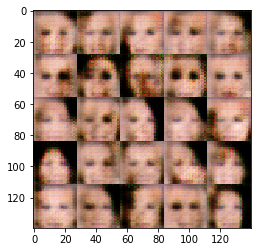

Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 1.1336
Epoch 1/1... Discriminator Loss: 1.0291... Generator Loss: 1.8498
Epoch 1/1... Discriminator Loss: 1.0404... Generator Loss: 1.0675
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 1.2501
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.6303
Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.6250
Epoch 1/1... Discriminator Loss: 1.0674... Generator Loss: 1.8214
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 2.4470
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 1.6936
Epoch 1/1... Discriminator Loss: 1.7160... Generator Loss: 0.4445


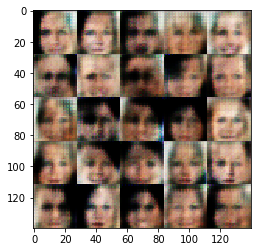

Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.8682
Epoch 1/1... Discriminator Loss: 0.8067... Generator Loss: 1.4400
Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 1.3322
Epoch 1/1... Discriminator Loss: 1.2307... Generator Loss: 2.0030
Epoch 1/1... Discriminator Loss: 1.1934... Generator Loss: 1.0818
Epoch 1/1... Discriminator Loss: 1.1710... Generator Loss: 1.1854
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 1.3221
Epoch 1/1... Discriminator Loss: 1.5632... Generator Loss: 2.1250
Epoch 1/1... Discriminator Loss: 1.0406... Generator Loss: 2.1470


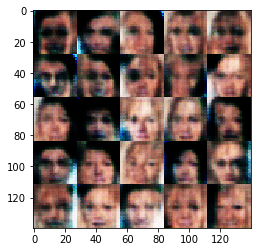

Epoch 1/1... Discriminator Loss: 1.2084... Generator Loss: 1.0626
Epoch 1/1... Discriminator Loss: 1.8166... Generator Loss: 0.3034
Epoch 1/1... Discriminator Loss: 0.8263... Generator Loss: 1.5759
Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 0.8641
Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 1.1234
Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 0.6135
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.8185
Epoch 1/1... Discriminator Loss: 1.0470... Generator Loss: 1.3890
Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 1.2132


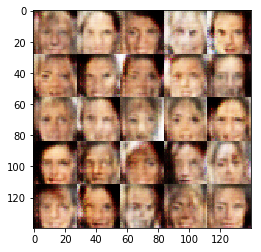

Epoch 1/1... Discriminator Loss: 1.5092... Generator Loss: 0.5714
Epoch 1/1... Discriminator Loss: 1.6351... Generator Loss: 0.8678
Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 1.2355
Epoch 1/1... Discriminator Loss: 1.0927... Generator Loss: 0.9387
Epoch 1/1... Discriminator Loss: 1.6096... Generator Loss: 1.2582
Epoch 1/1... Discriminator Loss: 1.1050... Generator Loss: 1.2715
Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 0.5941
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 1.7079
Epoch 1/1... Discriminator Loss: 1.0123... Generator Loss: 1.2271
Epoch 1/1... Discriminator Loss: 1.6597... Generator Loss: 0.4471


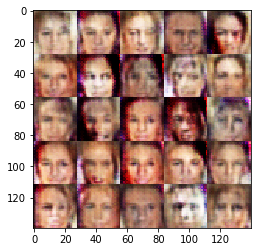

Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 1.0205
Epoch 1/1... Discriminator Loss: 1.2713... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.2903... Generator Loss: 0.8753
Epoch 1/1... Discriminator Loss: 1.6671... Generator Loss: 2.1787
Epoch 1/1... Discriminator Loss: 1.6497... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.4640... Generator Loss: 0.6167
Epoch 1/1... Discriminator Loss: 1.6083... Generator Loss: 0.5756
Epoch 1/1... Discriminator Loss: 1.5891... Generator Loss: 0.9127
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.5890
Epoch 1/1... Discriminator Loss: 1.1697... Generator Loss: 1.1663


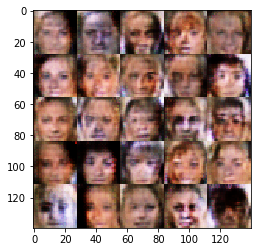

Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 2.6744
Epoch 1/1... Discriminator Loss: 1.0235... Generator Loss: 0.8424
Epoch 1/1... Discriminator Loss: 1.0318... Generator Loss: 1.1330
Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 1.3023
Epoch 1/1... Discriminator Loss: 1.6495... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.1498... Generator Loss: 1.1554
Epoch 1/1... Discriminator Loss: 0.9220... Generator Loss: 1.4081
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 0.9745
Epoch 1/1... Discriminator Loss: 1.5318... Generator Loss: 1.1450


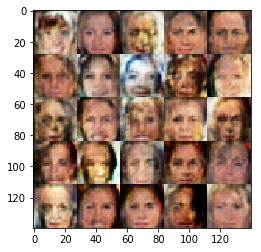

Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 1.0217
Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 1.2499
Epoch 1/1... Discriminator Loss: 0.9790... Generator Loss: 0.9143
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.6501
Epoch 1/1... Discriminator Loss: 1.2287... Generator Loss: 1.0254
Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.6021... Generator Loss: 1.4480
Epoch 1/1... Discriminator Loss: 1.0411... Generator Loss: 1.4867
Epoch 1/1... Discriminator Loss: 1.4987... Generator Loss: 1.3743
Epoch 1/1... Discriminator Loss: 1.4749... Generator Loss: 0.8310


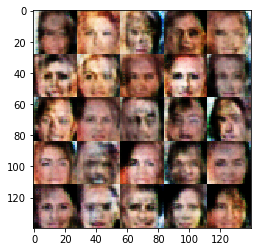

Epoch 1/1... Discriminator Loss: 1.4634... Generator Loss: 0.8264
Epoch 1/1... Discriminator Loss: 0.8199... Generator Loss: 1.4950
Epoch 1/1... Discriminator Loss: 1.5663... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.4598... Generator Loss: 0.5636
Epoch 1/1... Discriminator Loss: 1.0890... Generator Loss: 0.9735
Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 1.1198
Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 0.8953
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.0110... Generator Loss: 1.7463
Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.5670


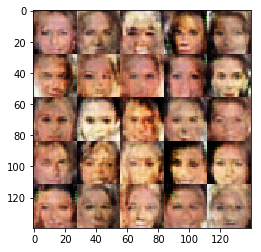

Epoch 1/1... Discriminator Loss: 1.2634... Generator Loss: 1.2549
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 1.3637
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 1.0105
Epoch 1/1... Discriminator Loss: 1.2326... Generator Loss: 0.9520
Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 0.8816
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 0.9814
Epoch 1/1... Discriminator Loss: 1.1027... Generator Loss: 1.8740
Epoch 1/1... Discriminator Loss: 1.2189... Generator Loss: 0.9720
Epoch 1/1... Discriminator Loss: 1.8186... Generator Loss: 0.3591


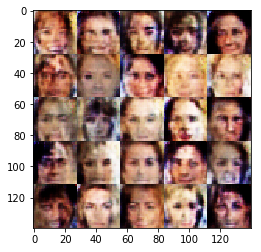

Epoch 1/1... Discriminator Loss: 1.0746... Generator Loss: 1.9035
Epoch 1/1... Discriminator Loss: 1.2822... Generator Loss: 0.9089
Epoch 1/1... Discriminator Loss: 0.9626... Generator Loss: 1.2269
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.3039... Generator Loss: 1.1232
Epoch 1/1... Discriminator Loss: 1.1022... Generator Loss: 2.0973
Epoch 1/1... Discriminator Loss: 1.2903... Generator Loss: 1.1955
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.7382
Epoch 1/1... Discriminator Loss: 1.3195... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.6441


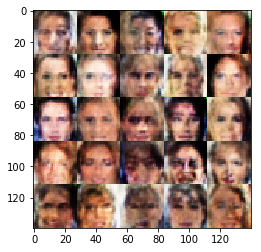

Epoch 1/1... Discriminator Loss: 1.5143... Generator Loss: 0.5738
Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.9037
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 1.2621
Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.5172
Epoch 1/1... Discriminator Loss: 1.1257... Generator Loss: 1.8785
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 1.1572
Epoch 1/1... Discriminator Loss: 1.5223... Generator Loss: 0.4978
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 0.8350
Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.8841


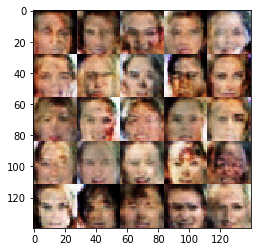

Epoch 1/1... Discriminator Loss: 1.1879... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 1.0267
Epoch 1/1... Discriminator Loss: 1.4966... Generator Loss: 0.6448
Epoch 1/1... Discriminator Loss: 1.1138... Generator Loss: 1.1679
Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 0.9953
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 1.0299
Epoch 1/1... Discriminator Loss: 1.2574... Generator Loss: 0.9297
Epoch 1/1... Discriminator Loss: 1.5006... Generator Loss: 0.6503
Epoch 1/1... Discriminator Loss: 1.0597... Generator Loss: 1.0267
Epoch 1/1... Discriminator Loss: 1.2872... Generator Loss: 0.8119


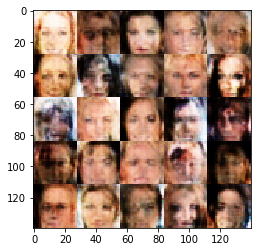

Epoch 1/1... Discriminator Loss: 1.2095... Generator Loss: 1.0021
Epoch 1/1... Discriminator Loss: 1.1702... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.2257... Generator Loss: 0.9227
Epoch 1/1... Discriminator Loss: 1.2199... Generator Loss: 0.9172
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 1.0622
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.5570... Generator Loss: 0.6806
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.9981
Epoch 1/1... Discriminator Loss: 1.2993... Generator Loss: 0.9478
Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 1.2336


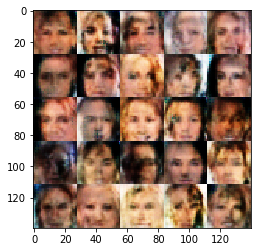

Epoch 1/1... Discriminator Loss: 1.4758... Generator Loss: 0.4584
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 0.9641
Epoch 1/1... Discriminator Loss: 1.4962... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.9237
Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 0.9763
Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.7169
Epoch 1/1... Discriminator Loss: 1.5206... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.7105
Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.2086... Generator Loss: 0.7792


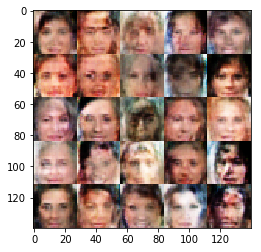

Epoch 1/1... Discriminator Loss: 1.1194... Generator Loss: 1.1335
Epoch 1/1... Discriminator Loss: 1.0828... Generator Loss: 1.5318
Epoch 1/1... Discriminator Loss: 1.1011... Generator Loss: 1.2806
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.8378
Epoch 1/1... Discriminator Loss: 1.2938... Generator Loss: 1.0325
Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 1.0455
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.7411
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 1.6785
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.6873


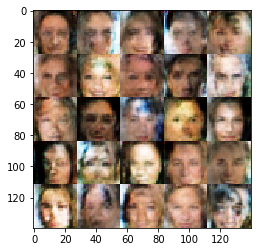

Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 1.3025
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.7586
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 1.0200
Epoch 1/1... Discriminator Loss: 1.4908... Generator Loss: 0.6943
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.9007
Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 1.2627
Epoch 1/1... Discriminator Loss: 1.0011... Generator Loss: 2.0407
Epoch 1/1... Discriminator Loss: 1.4775... Generator Loss: 0.6031


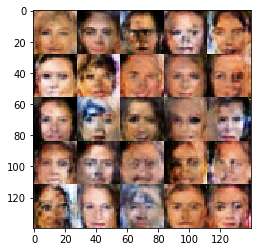

Epoch 1/1... Discriminator Loss: 1.5081... Generator Loss: 0.6359
Epoch 1/1... Discriminator Loss: 1.5368... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 1.6535... Generator Loss: 0.9472
Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 1.2516
Epoch 1/1... Discriminator Loss: 1.2697... Generator Loss: 1.0296
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.8594
Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.8419
Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 1.0231
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 1.0585


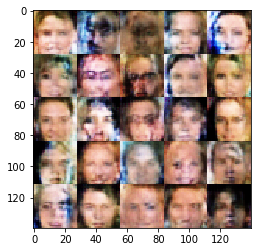

Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.6318
Epoch 1/1... Discriminator Loss: 1.5777... Generator Loss: 0.5323
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.9680
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 1.2480
Epoch 1/1... Discriminator Loss: 1.4714... Generator Loss: 0.9744
Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 1.2036
Epoch 1/1... Discriminator Loss: 1.2275... Generator Loss: 0.9123
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.5093
Epoch 1/1... Discriminator Loss: 1.2786... Generator Loss: 0.7060


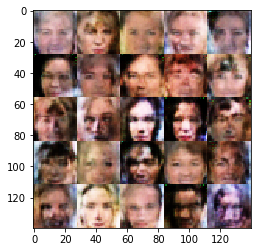

Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.8416
Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 1.2198
Epoch 1/1... Discriminator Loss: 1.4932... Generator Loss: 1.0750
Epoch 1/1... Discriminator Loss: 1.4761... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 1.5232... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.6605... Generator Loss: 0.4089
Epoch 1/1... Discriminator Loss: 1.5484... Generator Loss: 0.6527
Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 0.9876
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 1.0265


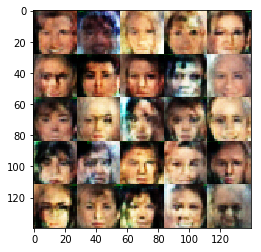

Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.6267... Generator Loss: 0.5729
Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.6183
Epoch 1/1... Discriminator Loss: 1.5738... Generator Loss: 0.4682
Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.6041
Epoch 1/1... Discriminator Loss: 1.4470... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.6453... Generator Loss: 0.5547
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.8369


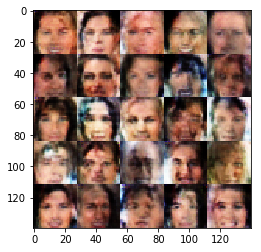

Epoch 1/1... Discriminator Loss: 1.5453... Generator Loss: 0.9327
Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 1.2541
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 1.0208
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 1.1501
Epoch 1/1... Discriminator Loss: 1.6230... Generator Loss: 1.3004
Epoch 1/1... Discriminator Loss: 1.4781... Generator Loss: 0.8285
Epoch 1/1... Discriminator Loss: 1.1989... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.7267
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.9032


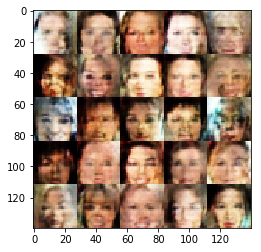

Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 1.1282
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 0.9636
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 1.0691
Epoch 1/1... Discriminator Loss: 1.2176... Generator Loss: 0.8368
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 1.4787... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.9444
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.9255


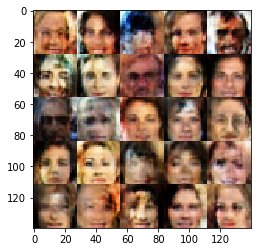

Epoch 1/1... Discriminator Loss: 1.5189... Generator Loss: 0.5628
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 1.0815
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.9907
Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.5221... Generator Loss: 0.8658
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.9703
Epoch 1/1... Discriminator Loss: 1.5527... Generator Loss: 0.4715
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.6522
Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.9063


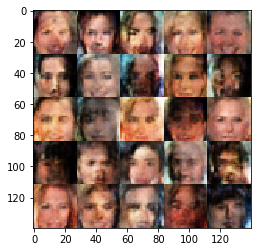

Epoch 1/1... Discriminator Loss: 1.2286... Generator Loss: 0.8390
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.8787
Epoch 1/1... Discriminator Loss: 1.4672... Generator Loss: 0.9599
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.5266
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.7797
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 1.2229
Epoch 1/1... Discriminator Loss: 1.1272... Generator Loss: 1.0714
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.6329
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 1.0044


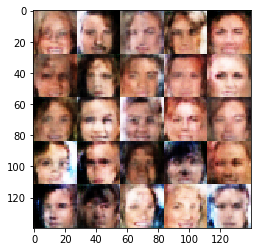

Epoch 1/1... Discriminator Loss: 1.4711... Generator Loss: 0.6834
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.4787... Generator Loss: 0.6382
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 0.9392
Epoch 1/1... Discriminator Loss: 1.5115... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.2529... Generator Loss: 1.0029
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.8720
Epoch 1/1... Discriminator Loss: 1.2076... Generator Loss: 1.0460
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.8565
Epoch 1/1... Discriminator Loss: 1.6747... Generator Loss: 0.4874


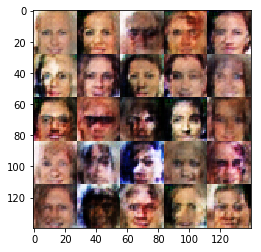

Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 0.8865
Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 1.1449
Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 0.8815
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 1.4991... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.9130
Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.5697


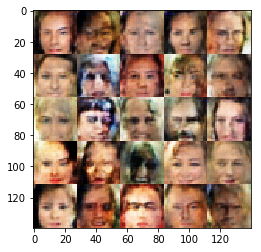

Epoch 1/1... Discriminator Loss: 1.5063... Generator Loss: 0.5937
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.9399
Epoch 1/1... Discriminator Loss: 1.5709... Generator Loss: 0.5645
Epoch 1/1... Discriminator Loss: 1.5997... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.8394
Epoch 1/1... Discriminator Loss: 1.5052... Generator Loss: 1.1285
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.9612
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.9030


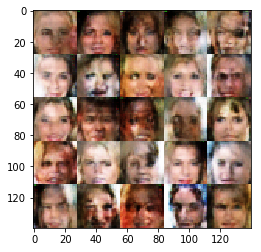

Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 1.1101
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 1.1211
Epoch 1/1... Discriminator Loss: 1.4986... Generator Loss: 0.5967
Epoch 1/1... Discriminator Loss: 1.2961... Generator Loss: 0.8699
Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 1.0430
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.9417


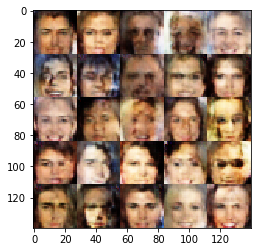

Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.6148
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.8859
Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 0.9096
Epoch 1/1... Discriminator Loss: 1.8651... Generator Loss: 0.4939
Epoch 1/1... Discriminator Loss: 1.2973... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 0.6540
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 0.9463
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 1.0454
Epoch 1/1... Discriminator Loss: 1.4817... Generator Loss: 0.9245


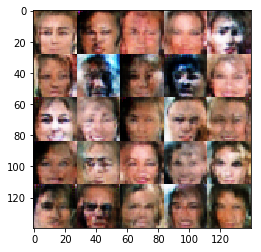

Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.5322
Epoch 1/1... Discriminator Loss: 1.5604... Generator Loss: 0.5487
Epoch 1/1... Discriminator Loss: 1.5800... Generator Loss: 1.0128
Epoch 1/1... Discriminator Loss: 1.1796... Generator Loss: 0.9865
Epoch 1/1... Discriminator Loss: 1.4617... Generator Loss: 0.7646
Epoch 1/1... Discriminator Loss: 1.5263... Generator Loss: 1.1015
Epoch 1/1... Discriminator Loss: 1.2272... Generator Loss: 1.1570
Epoch 1/1... Discriminator Loss: 1.4641... Generator Loss: 0.6471
Epoch 1/1... Discriminator Loss: 1.0113... Generator Loss: 2.2667
Epoch 1/1... Discriminator Loss: 1.4761... Generator Loss: 0.6353


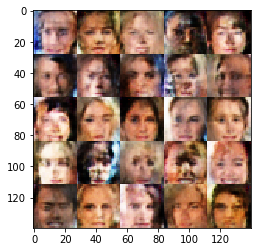

Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 1.0653
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.9146
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 1.1595
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.8760
Epoch 1/1... Discriminator Loss: 1.1860... Generator Loss: 0.9303
Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.7629
Epoch 1/1... Discriminator Loss: 1.4947... Generator Loss: 0.9326
Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.9593
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.9113


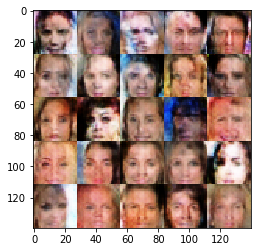

Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.9077
Epoch 1/1... Discriminator Loss: 1.5862... Generator Loss: 1.2145
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.8604
Epoch 1/1... Discriminator Loss: 1.3283... Generator Loss: 0.9300
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 1.0090
Epoch 1/1... Discriminator Loss: 1.2090... Generator Loss: 1.0253
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 0.8570


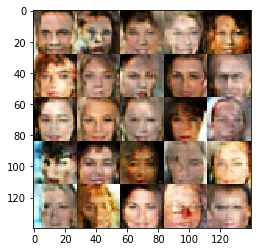

Epoch 1/1... Discriminator Loss: 1.5055... Generator Loss: 0.6755
Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.8102
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 1.0318
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 1.5128
Epoch 1/1... Discriminator Loss: 1.6190... Generator Loss: 0.6219
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.7382
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.8207
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.9214
Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 1.0359


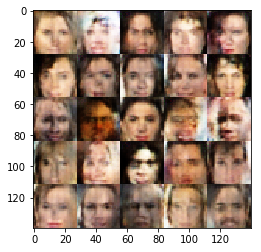

Epoch 1/1... Discriminator Loss: 1.6077... Generator Loss: 0.8966
Epoch 1/1... Discriminator Loss: 1.2418... Generator Loss: 0.9989
Epoch 1/1... Discriminator Loss: 1.5116... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.5243... Generator Loss: 1.1344
Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.6351
Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.9679
Epoch 1/1... Discriminator Loss: 1.5120... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.6168
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.8203


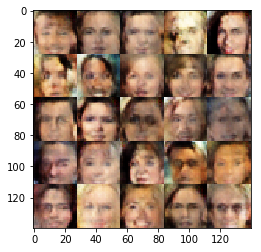

Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 1.0357
Epoch 1/1... Discriminator Loss: 1.4617... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.4974... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.9480
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 1.0120
Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.8994
Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 1.0461
Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 1.6784... Generator Loss: 0.3797


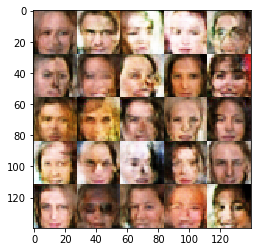

Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 0.8285
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.7166
Epoch 1/1... Discriminator Loss: 1.2888... Generator Loss: 0.9397
Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 0.9204
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 1.6456... Generator Loss: 0.5287
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 1.1158


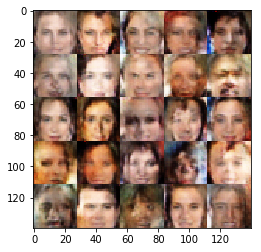

Epoch 1/1... Discriminator Loss: 1.4810... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.4672... Generator Loss: 0.7078
Epoch 1/1... Discriminator Loss: 1.4756... Generator Loss: 0.8169
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 1.0739
Epoch 1/1... Discriminator Loss: 1.5840... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.8678
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.8386
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.8363


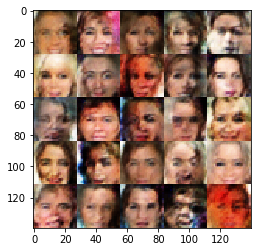

Epoch 1/1... Discriminator Loss: 1.4833... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 1.3501
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.7059
Epoch 1/1... Discriminator Loss: 1.4917... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 1.0058
Epoch 1/1... Discriminator Loss: 1.4707... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 0.9662
Epoch 1/1... Discriminator Loss: 1.4832... Generator Loss: 0.8031
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.8071


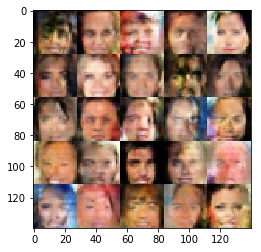

Epoch 1/1... Discriminator Loss: 1.7514... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.7138
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.8451
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.9718
Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.7482
Epoch 1/1... Discriminator Loss: 1.6424... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.8318
Epoch 1/1... Discriminator Loss: 1.5306... Generator Loss: 0.6221
Epoch 1/1... Discriminator Loss: 1.2158... Generator Loss: 1.0063


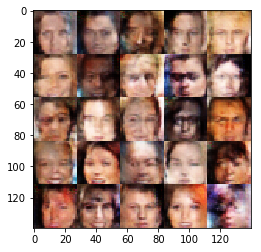

Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.8514
Epoch 1/1... Discriminator Loss: 1.7127... Generator Loss: 0.4392
Epoch 1/1... Discriminator Loss: 1.2030... Generator Loss: 0.8344
Epoch 1/1... Discriminator Loss: 1.6851... Generator Loss: 0.4894
Epoch 1/1... Discriminator Loss: 1.5548... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.4852... Generator Loss: 0.9777
Epoch 1/1... Discriminator Loss: 1.4967... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.8397


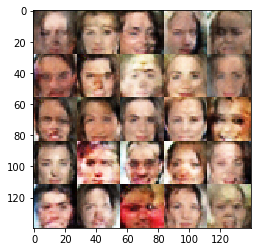

Epoch 1/1... Discriminator Loss: 1.5537... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 0.8805
Epoch 1/1... Discriminator Loss: 1.2967... Generator Loss: 0.9287
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.9004
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 1.0089
Epoch 1/1... Discriminator Loss: 1.5233... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.9627
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.8489
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.8709
Epoch 1/1... Discriminator Loss: 1.6246... Generator Loss: 0.6788


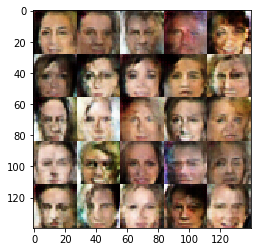

Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 0.9823
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.9019
Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 0.8949
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.8329
Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.9067
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 0.9538
Epoch 1/1... Discriminator Loss: 1.5093... Generator Loss: 0.5528
Epoch 1/1... Discriminator Loss: 1.4458... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.5317... Generator Loss: 0.9320


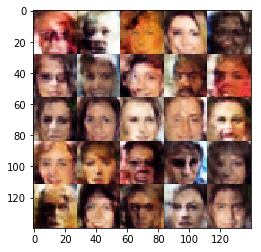

Epoch 1/1... Discriminator Loss: 1.5811... Generator Loss: 0.7998
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 1.0984
Epoch 1/1... Discriminator Loss: 1.4923... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.5174... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 1.1057
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.8235
Epoch 1/1... Discriminator Loss: 1.5556... Generator Loss: 0.5673
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.8953
Epoch 1/1... Discriminator Loss: 1.5197... Generator Loss: 0.6944


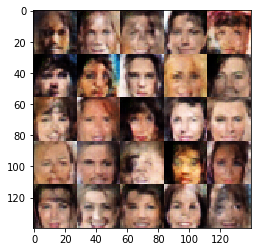

Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 1.4115
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.9085
Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 0.9691
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.9511
Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.9111
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.9455
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.8986
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.7411
Epoch 1/1... Discriminator Loss: 1.1457... Generator Loss: 1.4508
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.9683


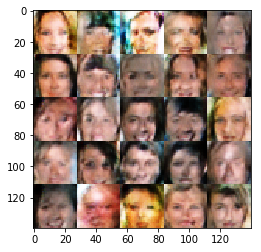

Epoch 1/1... Discriminator Loss: 1.5551... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 1.3166... Generator Loss: 0.9433
Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.8932
Epoch 1/1... Discriminator Loss: 1.2477... Generator Loss: 0.8218
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.9177
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.8369


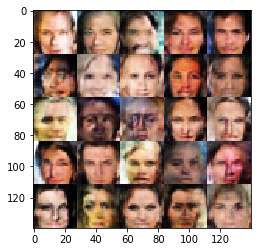

Epoch 1/1... Discriminator Loss: 1.4601... Generator Loss: 1.0231
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.7710
Epoch 1/1... Discriminator Loss: 1.6219... Generator Loss: 0.5504
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.8820
Epoch 1/1... Discriminator Loss: 1.5238... Generator Loss: 0.6256
Epoch 1/1... Discriminator Loss: 1.5106... Generator Loss: 0.8492
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.6614
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.8419
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.6280


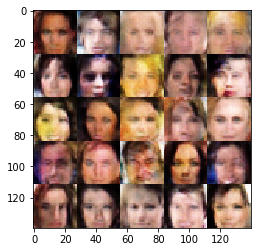

Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.8162
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.5777
Epoch 1/1... Discriminator Loss: 1.4947... Generator Loss: 0.8956
Epoch 1/1... Discriminator Loss: 1.5073... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.6989
Epoch 1/1... Discriminator Loss: 1.5130... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.9129
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.6558
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.6287


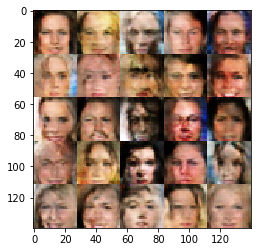

Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 0.8416
Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.9408
Epoch 1/1... Discriminator Loss: 1.4737... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.9045
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.9064
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.9494
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.6847
Epoch 1/1... Discriminator Loss: 1.4711... Generator Loss: 0.8514


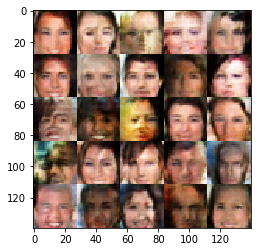

Epoch 1/1... Discriminator Loss: 1.5092... Generator Loss: 0.7116
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.9443
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.9143
Epoch 1/1... Discriminator Loss: 1.5283... Generator Loss: 0.6172
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.9509
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 1.1394
Epoch 1/1... Discriminator Loss: 1.4634... Generator Loss: 0.5528
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.8795


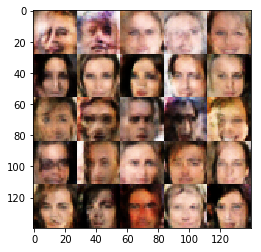

Epoch 1/1... Discriminator Loss: 1.4901... Generator Loss: 0.6801
Epoch 1/1... Discriminator Loss: 1.4707... Generator Loss: 0.9283
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.8540
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.9708
Epoch 1/1... Discriminator Loss: 1.4938... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.4716... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.9749
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 0.9528


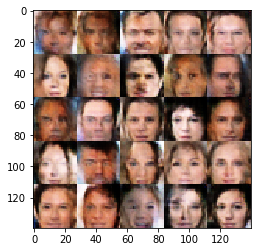

Epoch 1/1... Discriminator Loss: 1.5234... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 1.5867... Generator Loss: 0.8225
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.9764
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.6030
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 1.5197... Generator Loss: 0.9761
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.6245... Generator Loss: 0.7917


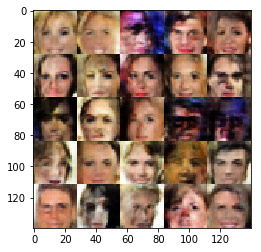

Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.8909
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 0.9162
Epoch 1/1... Discriminator Loss: 1.5602... Generator Loss: 0.8613
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.9036
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.9007
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.9212
Epoch 1/1... Discriminator Loss: 1.4891... Generator Loss: 0.8711
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.7469


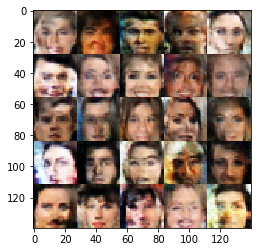

Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.1857... Generator Loss: 0.9842
Epoch 1/1... Discriminator Loss: 1.5827... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 1.0097
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.9266
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.5427
Epoch 1/1... Discriminator Loss: 1.4786... Generator Loss: 0.7442
Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.8321
Epoch 1/1... Discriminator Loss: 1.4964... Generator Loss: 0.6692


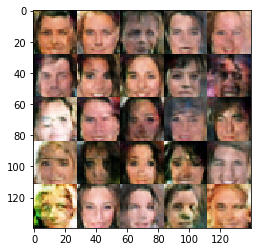

Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.4723... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.6705... Generator Loss: 0.6324
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 0.9437
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.8472
Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.9129
Epoch 1/1... Discriminator Loss: 1.5125... Generator Loss: 0.6472
Epoch 1/1... Discriminator Loss: 1.5181... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.8452


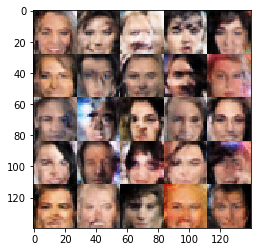

Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.7308
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.4586... Generator Loss: 0.9956
Epoch 1/1... Discriminator Loss: 1.2717... Generator Loss: 0.9028
Epoch 1/1... Discriminator Loss: 1.5893... Generator Loss: 0.9404
Epoch 1/1... Discriminator Loss: 1.7176... Generator Loss: 0.8100
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.5609... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.7250


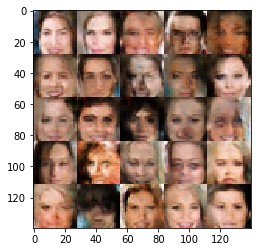

Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.2926... Generator Loss: 0.9055
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.8017
Epoch 1/1... Discriminator Loss: 1.5220... Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 1.5070... Generator Loss: 0.8637
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 1.5086... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.9907


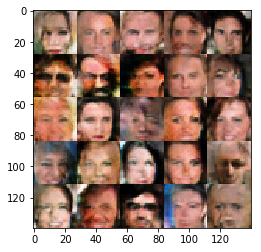

Epoch 1/1... Discriminator Loss: 1.5704... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.8641
Epoch 1/1... Discriminator Loss: 1.5500... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 1.5500... Generator Loss: 0.8697
Epoch 1/1... Discriminator Loss: 1.5321... Generator Loss: 0.8308
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 1.0107
Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 1.0387
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.8968


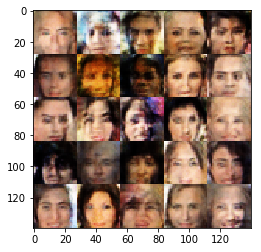

Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.6726... Generator Loss: 0.6442
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 1.2084
Epoch 1/1... Discriminator Loss: 1.4926... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.4910... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.9499
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 1.4843... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.7909


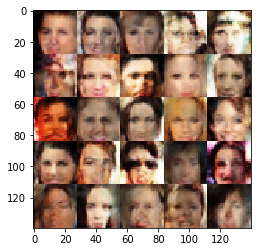

Epoch 1/1... Discriminator Loss: 1.5030... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.4837... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 0.8630
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.8118
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 0.9339
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.8386


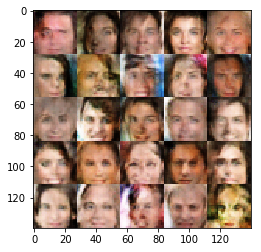

Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.8318
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.6173
Epoch 1/1... Discriminator Loss: 1.3123... Generator Loss: 0.9710
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 1.4527... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 1.4807... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.5980... Generator Loss: 0.7718


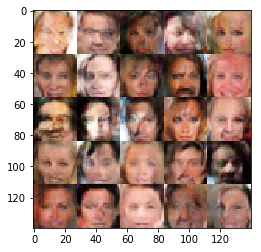

Epoch 1/1... Discriminator Loss: 1.5273... Generator Loss: 0.7229
Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.9652


In [28]:
batch_size = 32
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.